In [13]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from pycbc import psd as psd_func
from pycbc.filter import sigma, match, matched_filter
from pycbc.filter.matchedfilter import quadratic_interpolate_peak
from pycbc.noise import frequency_noise_from_psd
from simple_pe.waveforms import make_waveform, calc_f_gen, two_ecc_harms_SNR, calculate_mode_snr, generate_eccentric_waveform_MA
from calcwf import match_hn

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# e=0.2, chirp=24

In [2]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:390: RuntimeWarning: divide by zero encountered in divide
  return self._data.__rtruediv__(other)


## Performing direct match to data

### Exact degeneracy line

In [3]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [15]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s_ = np.linspace(0.1, 0.3, 21)
for i, e10 in enumerate(e10s_):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s_)}', end='')

1 complete out of 21


KeyboardInterrupt



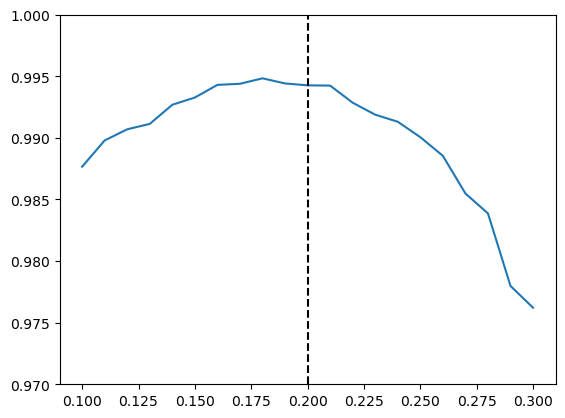

In [7]:
# Plot results
plt.plot(e10s_, data_matches_)
plt.ylim(0.97,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

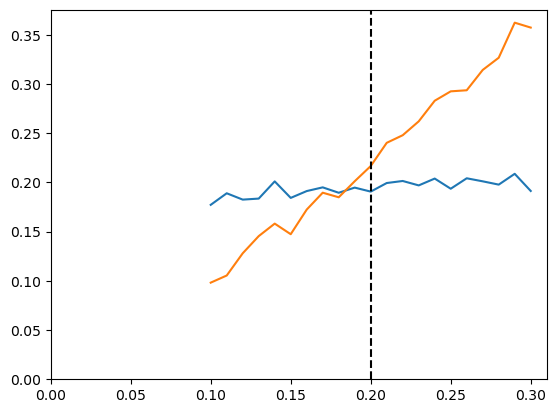

In [8]:
# Plot results
plt.plot(e10s_, data_ecc_SNRs_)
plt.plot(e10s_, trial_ecc_SNRs_)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

### Imperfect degeneracy line

In [9]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [12]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.05, 0.25, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s__)}', end='')

21 complete out of 21

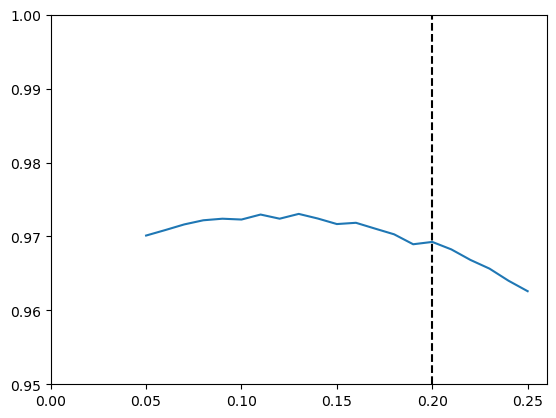

In [13]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.95,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

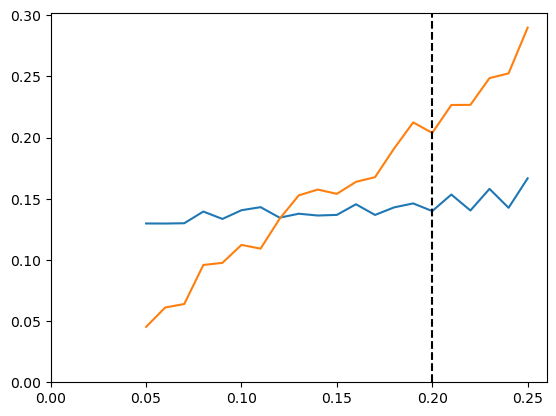

In [14]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# e=0.3, chirp=16

In [ ]:
# Data settings
true_dict = {'ecc10sqrd': 0.3**2, 'chirp_mass': 16, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': data.to_timeseries()*target_snr/raw_snr}
true_dict['distance'] = raw_snr/target_snr

## Performing direct match to data

### Exact degeneracy line

In [ ]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [ ]:
# Loop over distance along degeneracy line
data_ecc_SNRs_ = []
trial_ecc_SNRs_ = []
data_matches_ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s = np.linspace(0, 0.5, 21)
for i, e10 in enumerate(e10s):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs_.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches_.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs_.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

In [ ]:
# Plot results
plt.plot(e10s, data_matches_)
plt.ylim(0.9,1)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

### Imperfect degeneracy line

In [ ]:
# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_1/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

In [ ]:
# Loop over distance along degeneracy line
data_ecc_SNRs__ = []
trial_ecc_SNRs__ = []
data_matches__ = []
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
e10s__ = np.linspace(0.2, 0.4, 21)
for i, e10 in enumerate(e10s__):
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Make eccentric harmonics and match to data
    ecc_harms = make_waveform(params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
    wf_hjs = [ecc_harms[k].to_timeseries() for k in [0, 1, -1, 2]]
    f_gen = calc_f_gen(f_low, 4)
    match_cplx = match_hn(wf_hjs, data['H1'], f_gen, psd=psd['H1'], f_match=f_low)
    # data_ecc_SNR = np.abs(match_cplx[1])/np.abs(match_cplx[0])
    # target_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0])) % (2*np.pi)
    data_ecc_SNR, target_MA = two_ecc_harms_SNR({0: np.abs(match_cplx[0]), 1: np.abs(match_cplx[1]), -1: np.abs(match_cplx[2])},
                                                {0: np.angle(match_cplx[0]), 1: np.angle(match_cplx[1]), -1: np.angle(match_cplx[2])})
    data_ecc_SNR = data_ecc_SNR*np.exp(1j*target_MA)
    data_ecc_SNRs__.append(np.abs(data_ecc_SNR))
    
    # Calculate trial waveform with correct MA and match to data
    two_ecc_harms=True
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_match, _ = match(data['H1'], trial_wf, psd=psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
    data_matches__.append(data_match)

    # Match trial waveform to eccentric harmonics
    trial_z, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                    trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0)
    if two_ecc_harms:
        harm_ids = [0, 1, -1]
        ecc_SNR_abs, ecc_SNR_ang = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in harm_ids},
            {k: np.angle(trial_z[k]) for k in harm_ids})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
        ecc_SNR_ang = (np.angle(trial_z[1])-np.angle(trial_z[0])) % (2*np.pi)
    trial_ecc_SNR = ecc_SNR_abs*np.exp(1j*ecc_SNR_ang)
    trial_ecc_SNRs__.append(np.abs(trial_ecc_SNR))

    print(f'\r{i+1} complete out of {len(e10s)}', end='')

In [ ]:
# Plot results
plt.plot(e10s__, data_matches__)
plt.ylim(0.8,1)
plt.xlim(0,)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.show()

In [ ]:
# Plot results
plt.plot(e10s__, data_ecc_SNRs__)
plt.plot(e10s__, trial_ecc_SNRs__)
plt.axvline(true_dict['ecc10sqrd']**0.5, c='k', ls='dashed')
plt.ylim(0,)
plt.xlim(0,)
plt.show()

# Method

In [25]:
def gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True, return_all=False):

    # Make eccentric harmonics
    ecc_harms = make_waveform(params, psd.delta_f, f_low, len(psd), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=n_ecc_harms)
    f_gen = calc_f_gen(f_low, n_ecc_harms)

    # Match harmonics to data
    mode_SNRs, _ = calculate_mode_snr(data, psd, ecc_harms, data.sample_times[0],
                                      data.sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
    if two_ecc_harms:
        data_ecc_SNR, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                                    {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
    else:
        data_ecc_SNR = np.abs(mode_SNRs[1])/np.abs(mode_SNRs[0])
        target_MA = (np.angle(mode_SNRs[1])-np.angle(mode_SNRs[0])) % (2*np.pi)

    # Make trial waveform at correct MA and match to data
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)

    if return_all:
        return trial_wf, ecc_harms, data_ecc_SNR
    return trial_wf

In [26]:
def test_ecc_point(e10, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):
    
    # Make param dictionary
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Create harmonics and trial waveform
    trial_wf = gen_test_wfs(data, params, f_low, psd, n_ecc_harms, two_ecc_harms=True)
    data_snr = matched_filter(trial_wf, data, psd, low_frequency_cutoff=f_low,
                              high_frequency_cutoff=psd.sample_frequencies[-1])
    maxsnr, max_id = data_snr.abs_max_loc()
    left = abs(data_snr[-1]) if max_id == 0 else abs(data_snr[max_id - 1])
    right = abs(data_snr[0]) if max_id == (len(data_snr) - 1) else abs(data_snr[max_id + 1])
    _, maxsnr = quadratic_interpolate_peak(left, maxsnr, right)

    print(e10, maxsnr)

    return -maxsnr

In [27]:
def find_ecc_peak(data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):

    # Find initial guess
    first_params = {key: fid_dict[key] for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']}
    first_params['distance'] = 1
    first_trial_wf, first_ecc_harms, first_data_ecc_SNR = gen_test_wfs(data, first_params, f_low, psd, n_ecc_harms,
                                                                       two_ecc_harms=True, return_all=True)
    trial_z, _ = calculate_mode_snr(first_trial_wf, psd, first_ecc_harms, first_trial_wf.sample_times[0],
                                    first_trial_wf.sample_times[-1], f_low, first_ecc_harms.keys(),
                                    dominant_mode=0, subsample_interpolation=False)
    print({k: np.abs(trial_z[k]) for k in trial_z.keys()})
    if two_ecc_harms:
        ecc_SNR_abs, _ = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in [0, 1, -1]},
            {k: np.angle(trial_z[k]) for k in [0, 1, -1]})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
    init_e10 = (first_data_ecc_SNR/ecc_SNR_abs)*(fid_dict['ecc10sqrd']**0.5)
    print(ecc_SNR_abs, first_data_ecc_SNR, fid_dict['ecc10sqrd']**0.5)
    print(init_e10)
    print('')

    # Use scipy optimise to find maximum match
    bounds = [(0, 0.8)]
    peak_e10 = minimize(lambda x: test_ecc_point(x, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=two_ecc_harms),
                        init_e10, bounds=bounds, method='Nelder-Mead', options={'xatol': 0.003, 'fatol': np.inf})

    return peak_e10

In [28]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr).to_timeseries()}
# data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

start = time.time()
peak_e_10 = find_ecc_peak(data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
print(peak_e_10)
end = time.time()
print(f'{end-start} seconds')

{0: 33839.563385965725, 1: 3072.503139477776, -1: 1378.6469319018051, 2: 602.0702737715551}
0.09560131056174799 0.19128619824533385 [0.1041551]
[0.20840125]

[0.20840125] 19.913375769000336
[0.21882131] 19.992867293660098
[0.22924137] 19.98322735095186
[0.22403134] 19.989235684770836
[0.21361128] 19.996517337549612
[0.20840125] 19.913375769000336
[0.20840125] 19.913375755972034
[0.21621629] 19.9950434951175
 final_simplex: (array([[0.21361128],
       [0.21621629]]), array([-19.99651734, -19.9950435 ]))
           fun: -19.996517337549612
       message: 'Optimization terminated successfully.'
          nfev: 8
           nit: 4
        status: 0
       success: True
             x: array([0.21361128])
256.6543700695038 seconds


## Test method functions

In [29]:
def test_ecc_peak(eccs, data, base_dict, fid_dict, f_low, psd, n_ecc_harms):

    SNRs = []
    for i, e in enumerate(eccs):
        SNR = -test_ecc_point(e, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True)
        SNRs.append(SNR)
        print(f'\r{i+1} computed out of {len(eccs)}', end='')

    return SNRs

In [30]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr).to_timeseries()}
# data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

eccs = np.linspace(0.15, 0.25, 21)
start = time.time()
SNRs = test_ecc_peak(eccs, data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
end = time.time()
print(f'{end-start} seconds')

0.15 19.88422111351556
1 computed out of 210.155 19.89748136675505
2 computed out of 210.16 19.89600318860645
3 computed out of 210.16499999999999998 19.907688205869682
4 computed out of 210.16999999999999998 19.911679926623137
5 computed out of 210.175 19.918985779865185
6 computed out of 210.18 19.967326866079617
7 computed out of 210.185 19.923316585967694
8 computed out of 210.19 19.92872176686352
9 computed out of 210.195 19.92767337765714
10 computed out of 210.2 19.999999999999936
11 computed out of 210.205 19.99711231171066
12 computed out of 210.21 19.995162812230475
13 computed out of 210.215 19.98963120286478
14 computed out of 210.22 19.985929870209798
15 computed out of 210.22499999999999998 19.98441995990895
16 computed out of 210.22999999999999998 19.981184329115607
17 computed out of 210.235 19.961498597915668
18 computed out of 210.24 19.969255100104622
19 computed out of 210.245 19.959136338143626
20 computed out of 210.25 19.95087769933028
21 computed out of 21472.31

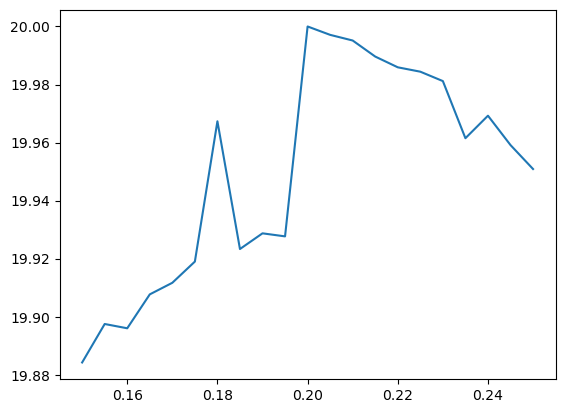

In [31]:
plt.plot(eccs, SNRs)
plt.show()

# Method with only fiducial harmonics generated

In [32]:
def test_ecc_point_fid_only(e10, data, base_dict, fid_dict, ecc_harms, target_MA, f_low, psd, two_ecc_harms=True):
    
    # Make param dictionary
    dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    params = {'distance': 1}
    param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
    for param in param_keys:
        params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]

    # Create  trial waveform
    params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
    params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))
    trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                              params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                              psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    data_snr = matched_filter(trial_wf, data, psd, low_frequency_cutoff=f_low,
                              high_frequency_cutoff=psd.sample_frequencies[-1])
    maxsnr, max_id = data_snr.abs_max_loc()
    left = abs(data_snr[-1]) if max_id == 0 else abs(data_snr[max_id - 1])
    right = abs(data_snr[0]) if max_id == (len(data_snr) - 1) else abs(data_snr[max_id + 1])
    _, maxsnr = quadratic_interpolate_peak(left, maxsnr, right)

    print(e10, maxsnr)

    return -maxsnr

In [33]:
def find_ecc_peak_fid_only(data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):

    # Find initial guess
    first_params = {key: fid_dict[key] for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']}
    first_params['distance'] = 1
    ecc_harms = make_waveform(first_params, psd.delta_f, f_low, len(psd), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=n_ecc_harms)
    mode_SNRs, _ = calculate_mode_snr(data, psd, ecc_harms, data.sample_times[0],
                                      data.sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
    if two_ecc_harms:
        first_data_ecc_SNR, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                                    {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
    else:
        first_data_ecc_SNR = np.abs(mode_SNRs[1])/np.abs(mode_SNRs[0])
        target_MA = (np.angle(mode_SNRs[1])-np.angle(mode_SNRs[0])) % (2*np.pi)
    first_params['inverted_mass_ratio'] = 1/q_from_eta(first_params['symmetric_mass_ratio'])
    first_params['total_mass'] = np.sum(component_masses_from_mchirp_q(first_params['chirp_mass'], first_params['inverted_mass_ratio']))
    first_trial_wf = generate_eccentric_waveform_MA(first_params['total_mass'], first_params['inverted_mass_ratio'],
                                                    first_params['ecc10sqrd']**0.5, first_params['chi_eff'], first_params['chi_eff'],
                                                    psd, f_low, target_MA, ecc_harms, two_ecc_harms=two_ecc_harms)
    trial_z, _ = calculate_mode_snr(first_trial_wf, psd, ecc_harms, first_trial_wf.sample_times[0],
                                    first_trial_wf.sample_times[-1], f_low, ecc_harms.keys(),
                                    dominant_mode=0, subsample_interpolation=False)
    print({k: np.abs(trial_z[k]) for k in trial_z.keys()})
    if two_ecc_harms:
        ecc_SNR_abs, _ = two_ecc_harms_SNR(
            {k: np.abs(trial_z[k]) for k in [0, 1, -1]},
            {k: np.angle(trial_z[k]) for k in [0, 1, -1]})
    else:
        ecc_SNR_abs = np.abs(trial_z[1]/trial_z[0])
    init_e10 = (first_data_ecc_SNR/ecc_SNR_abs)*(fid_dict['ecc10sqrd']**0.5)
    print(ecc_SNR_abs, first_data_ecc_SNR, fid_dict['ecc10sqrd']**0.5)
    print(init_e10)
    print('')

    # Use scipy optimise to find maximum match
    bounds = [(0, 0.8)]
    peak_e10 = minimize(lambda x: test_ecc_point_fid_only(x, data, base_dict, fid_dict, ecc_harms, target_MA, f_low, psd, two_ecc_harms=two_ecc_harms),
                        init_e10, bounds=bounds, method='Nelder-Mead', options={'xatol': 0.003, 'fatol': np.inf})

    return peak_e10

In [34]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr).to_timeseries()}
# data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

start = time.time()
peak_e_10 = find_ecc_peak_fid_only(data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
print(peak_e_10)
end = time.time()
print(f'{end-start} seconds')

{0: 33839.563385965725, 1: 3072.503139477776, -1: 1378.6469319018051, 2: 602.0702737715551}
0.09560131056174799 0.19128619824533385 [0.1041551]
[0.20840125]

[0.20840125] 19.99849662025071
[0.21882131] 19.99358197886872
[0.19798119] 19.977923938503274
[0.21361128] 19.991968493731346
[0.21361128] 19.991968493731346
[0.20319122] 19.99432980046033
[0.20579623] 19.991853897142555
[0.21100626] 19.984715061377873
 final_simplex: (array([[0.20840125],
       [0.21100626]]), array([-19.99849662, -19.98471506]))
           fun: -19.99849662025071
       message: 'Optimization terminated successfully.'
          nfev: 8
           nit: 3
        status: 0
       success: True
             x: array([0.20840125])
120.11747932434082 seconds


## Test method functions

In [35]:
def test_ecc_peak_fid_only(eccs, data, base_dict, fid_dict, f_low, psd, n_ecc_harms, two_ecc_harms=True):

    # Get harmonics and target MA
    first_params = {key: fid_dict[key] for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']}
    first_params['distance'] = 1
    ecc_harms = make_waveform(first_params, psd.delta_f, f_low, len(psd), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=n_ecc_harms)
    mode_SNRs, _ = calculate_mode_snr(data, psd, ecc_harms, data.sample_times[0],
                                      data.sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
    if two_ecc_harms:
        _, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                                    {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
    else:
        target_MA = (np.angle(mode_SNRs[1])-np.angle(mode_SNRs[0])) % (2*np.pi)

    # Get SNR for each point on degeneracy line
    SNRs = []
    for i, e in enumerate(eccs):
        SNR = -test_ecc_point_fid_only(e, data, base_dict, fid_dict, ecc_harms, target_MA, f_low, psd, two_ecc_harms=True)
        SNRs.append(SNR)
        print(f'\r{i+1} computed out of {len(eccs)}', end='')

    return SNRs

In [36]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr).to_timeseries()}
# data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

eccs = np.linspace(0.1, 0.3, 51)
start = time.time()
SNRs = test_ecc_peak(eccs, data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
end = time.time()
print(f'{end-start} seconds')

eccs_fid_only = np.linspace(0.1, 0.3, 51)
start = time.time()
SNRs_fid_only = test_ecc_peak_fid_only(eccs_fid_only, data['H1'], base_dict, fid_dict, f_low, psd['H1'], 4)
end = time.time()
print(f'{end-start} seconds')

0.1 19.77902462232245
1 computed out of 510.10400000000000001 19.794804883693104
2 computed out of 510.10800000000000001 19.804070653900855
3 computed out of 510.112 19.814114948683045
4 computed out of 510.116 19.82170015580942
5 computed out of 510.12000000000000001 19.834184063467898
6 computed out of 510.124 19.84252844029528
7 computed out of 510.128 19.849618177524732
8 computed out of 510.132 19.855308268169146
9 computed out of 510.136 19.864240756874537
10 computed out of 510.14 19.875455607916148
11 computed out of 510.14400000000000002 19.882368017790483
12 computed out of 510.14800000000000002 19.888971412886114
13 computed out of 510.15200000000000002 19.892096190703686
14 computed out of 510.156 19.897656064950063
15 computed out of 510.16 19.89600318860645
16 computed out of 510.164 19.91067380894544
17 computed out of 510.168 19.913313178729652
18 computed out of 510.17200000000000001 19.913693267877065
19 computed out of 510.176 19.9202523941691
20 computed out of 510.

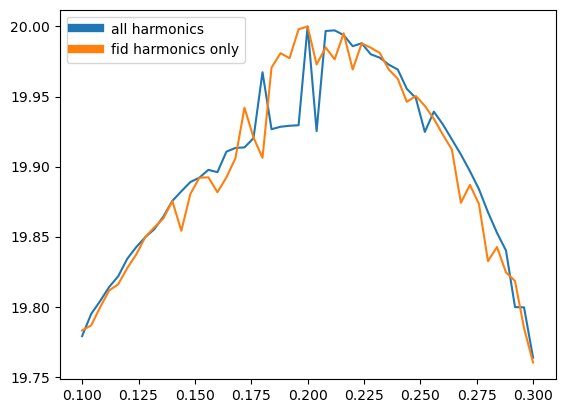

In [37]:
plt.plot(eccs, SNRs, label='all harmonics')
plt.plot(eccs_fid_only, SNRs_fid_only, label='fid harmonics only')
plt.legend()
plt.show()

# Verifying generate_eccentric_waveform_MA

In [47]:
from simple_pe.waveforms import shifted_f, shifted_e, generate_eccentric_waveform, compute_s_factor

def generate_eccentric_waveform_MA_test(M, q, ecc10, chi1, chi2, psd, f_low,
                                   target_MA, ecc_harms, two_ecc_harms=True,
                                   tol=0.03, max_iter=3):
    """
    Generates eccentric waveform with requested mean anomaly (MA) at merger
    by iteratively shifting frequency and eccentricity.

    :param M: total mass
    :type M: float, required
    :param q: inverted mass ratio
    :type q: float, required
    :param ecc10: eccentricity at 10Hz
    :type ecc10: float, required
    :param chi1: aligned spin of primary object
    :type chi1: float, required
    :param chi2: aligned spin of secondary object
    :type chi2: float, required
    :param psd: psd
    :type psd: FrequencySeries object, required
    :param f_low: initial frequency
    :type f_low: float, required
    :param target_MA: target mean anomaly at merger
    :type target_MA: float, required
    :param ecc_harms: eccentric harmonics used to calculate MA
    :type ecc_harms: dictionary of TimeSeries/FrequencySeries objects, required
    :param two_ecc_harms: whether to include two higher eccentric harmonics
    :type two_ecc_harms: boolean, optional
    :param tol: tolerance for convergence
    :type tol: float, optional
    :param max_iter: maximum number of iterations
    :type max_iter: integer, optional

    :return best_wf: waveform at requested parameters including MA
    :rtype best_wf: TimeSeries object
    """

    # Get psd parameters
    df = psd.delta_f
    flen = len(psd)
    s_rate = 2 * int(flen*df)
    tlen = int(1/df)
    e = shifted_e(f_low, 10, ecc10)

    # Initialise iteration
    current_tol = 2*np.pi
    best_tol = 2*np.pi
    current_iter = 0
    MA = 0
    s_factor = 1
    while current_tol > tol and current_iter <= max_iter:

        # Shift to f, e for requested MA
        s_f_2pi = (f_low - shifted_f(f_low, e, M, q))*s_factor
        s_f = f_low - s_f_2pi*MA/(2*np.pi)
        s_e = shifted_e(s_f, f_low, e)

        # Generate and match wf at requested MA
        hp, hc = generate_eccentric_waveform(M, q, s_e, chi1, chi2, s_f,
                                             s_rate, tlen=tlen, to_fs=False)
        h = hp - 1j*hc
        z, _ = calculate_mode_snr(hp, psd, ecc_harms, h.sample_times[0],
                                  h.sample_times[-1], f_low, ecc_harms.keys(),
                                  dominant_mode=0)
        if two_ecc_harms:
            harm_ids = [0, 1, -1]
            _, meas_MA = two_ecc_harms_SNR(
                {k: np.abs(z[k]) for k in harm_ids},
                {k: np.angle(z[k]) for k in harm_ids})
        else:
            meas_MA = (np.angle(z[1])-np.angle(z[0])) % (2*np.pi)

        # Calculate s_factor after first wf generation
        if current_iter == 0:
            s_f_max = shifted_f(f_low, e, M, q)
            s_e_max = shifted_e(s_f_max, f_low, e)
            sp, sc = generate_eccentric_waveform(
                M, q, s_e_max, chi1, chi2, s_f_max, s_rate, tlen=tlen,
                to_fs=False)
            s = sp - 1j*sc
            s_factor = compute_s_factor(h, s)

        # Update MA, tolerance, and iteration count
        MA_diff = (target_MA-meas_MA) % (2*np.pi)
        print(f'After iteration {current_iter+1}, we are using a shifting MA of {MA} to achieve a measured_MA of {meas_MA}. Target MA is {target_MA}')
        current_tol = np.abs((MA_diff+np.pi) % (2*np.pi)-np.pi)
        if current_tol < best_tol:
            best_tol = current_tol
            best_wf = hp
            best_MA = MA
        MA = (MA+MA_diff) % (2*np.pi)
        current_iter += 1
    
    print(f'Final shifting MA used of {best_MA} for a MA difference of {best_tol}.')

    return best_wf

In [10]:
# Data settings
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
target_snr = 20
f_low = 20
sample_rate = 4096
tlen = 32

# Create psd
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])
psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

# Generate data
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
true_dict['distance'] = 1
data = make_waveform(true_dict.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali')
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = {'H1': (data*target_snr/raw_snr).to_timeseries()}
# data = {'H1': (data*target_snr/raw_snr + frequency_noise_from_psd(psd['H1'], seed=12345)).to_timeseries()}
true_dict['distance'] = raw_snr/target_snr

# Get degeneracy line in roughly correct direction
with open('pe_4d_pipeline/dataslot_0/all_matches', 'rb') as fp:
    all_matches = pickle.load(fp)
base_dict = all_matches['metadata']['base_params']
fid_dict = all_matches['metadata']['fid_params']

# Shift degeneracy line to pass through true point
mult = true_dict['ecc10sqrd']/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
for key in ['chirp_mass', 'symmetric_mass_ratio', 'chi_eff']:
    proj_point = mult*(fid_dict[key]-base_dict[key])+base_dict[key]
    proj_diff = true_dict[key]-proj_point
    base_dict[key] += proj_diff
    fid_dict[key] += proj_diff

In [11]:
# Generate eccentric harmonics
first_params = {key: fid_dict[key] for key in ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']}
first_params['distance'] = 1
ecc_harms = make_waveform(first_params, psd['H1'].delta_f, f_low, len(psd['H1']), approximant='TEOBResumS-Dali-Harms', n_ecc_harms=4)
mode_SNRs, _ = calculate_mode_snr(data['H1'], psd['H1'], ecc_harms, data['H1'].sample_times[0],
                                  data['H1'].sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
first_data_ecc_SNR, target_MA = two_ecc_harms_SNR({k: np.abs(mode_SNRs[k]) for k in [0,1,-1]},
                                                  {k: np.angle(mode_SNRs[k]) for k in [0,1,-1]})
# target_MA = (np.angle(mode_SNRs[1])-np.angle(mode_SNRs[0])) % (2*np.pi)

for key in ecc_harms.keys():
    print(f'rho_{key}: {np.abs(mode_SNRs[key]):.2f}, phi_{key}: {np.angle(mode_SNRs[key])%(2*np.pi):.2f}')
print(f'Target MA: {target_MA:.2f}')

rho_0: 19.43, phi_0: 2.38
rho_1: 3.37, phi_1: 0.20
rho_-1: 1.81, phi_-1: 3.97
rho_2: 0.31, phi_2: 2.06
Target MA: 4.22


In [12]:
# Make param dictionary
e10 = true_dict['ecc10sqrd']**0.5
dist = (e10**2-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
params = {'distance': 1}
param_keys = ['ecc10sqrd', 'chirp_mass', 'symmetric_mass_ratio', 'chi_eff']
for param in param_keys:
    params[param] = dist*(fid_dict[param]-base_dict[param])+base_dict[param]
params['inverted_mass_ratio'] = 1/q_from_eta(params['symmetric_mass_ratio'])
params['total_mass'] = np.sum(component_masses_from_mchirp_q(params['chirp_mass'], params['inverted_mass_ratio']))

# Run generate_eccentric_waveform_MA on this point
trial_wf = generate_eccentric_waveform_MA(params['total_mass'], params['inverted_mass_ratio'],
                                               params['ecc10sqrd']**0.5, params['chi_eff'], params['chi_eff'],
                                               psd['H1'], f_low, target_MA, ecc_harms, two_ecc_harms=True)

# Match new waveform with eccentric harmonics
trial_mode_SNRs, _ = calculate_mode_snr(trial_wf, psd['H1'], ecc_harms, trial_wf.sample_times[0],
                                        trial_wf.sample_times[-1], f_low, ecc_harms.keys(), dominant_mode=0, subsample_interpolation=False)
trial_ecc_SNR, trial_MA = two_ecc_harms_SNR({k: np.abs(trial_mode_SNRs[k]) for k in [0,1,-1]},
                                             {k: np.angle(trial_mode_SNRs[k]) for k in [0,1,-1]})
print('')
for key in ecc_harms.keys():
    print(f'rho_{key}: {np.abs(trial_mode_SNRs[key]):.2f}, phi_{key}: {np.angle(trial_mode_SNRs[key])%(2*np.pi):.2f}')
print(f'Trial MA: {trial_MA:.2f}')

# Calculate match filter with data
data_snr = matched_filter(trial_wf, data['H1'], psd['H1'], low_frequency_cutoff=f_low,
                          high_frequency_cutoff=psd['H1'].sample_frequencies[-1])
maxsnr, max_id = data_snr.abs_max_loc()
left = abs(data_snr[-1]) if max_id == 0 else abs(data_snr[max_id - 1])
right = abs(data_snr[0]) if max_id == (len(data_snr) - 1) else abs(data_snr[max_id + 1])
_, maxsnr = quadratic_interpolate_peak(left, maxsnr, right)
print(f'\nSNR of trial wf in data: {maxsnr}')


rho_0: 32433.02, phi_0: 2.38
rho_1: 5621.95, phi_1: 0.20
rho_-1: 3029.77, phi_-1: 3.97
rho_2: 516.70, phi_2: 2.06
Trial MA: 4.22

SNR of trial wf in data: 19.999999999999936
